In [1]:
from google.colab import auth
auth.authenticate_user()

!gcloud config set project clever-aleph-203411

Updated property [core/project].


In [0]:
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/datasetv5.h5 dataset.h5

Copying gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/datasetv5.h5...


In [0]:
!mkdir models

In [0]:
import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
import h5py

In [0]:
f = h5py.File('dataset.h5', 'r')
x_train = f['x_train'][:]
y_train = f['y_train'][:]
x_test = f['x_test'][:-1300]
y_test = f['y_test'][:-1300]
f.close()

In [0]:
with h5py.File('dataset.h5', 'r') as f:
  x = f['x'][:]
  y = f['y'][:, 0]
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
  del x
  del y

In [0]:
batch_size = 32
epochs = 300

In [0]:
class SaveModel(Callback):
    def __init__(self, period=10):
        self.filepath = "/content/models/dbp-{epoch:02d}-{val_loss:.2f}.h5"
        self.gcsfile = "gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v12/dbp-{epoch:02d}-{val_loss:.2f}.h5"
        self.loss = None
        self.old_epoch = 0
        self.period = period
        
    def on_train_begin(self, logs={}):
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if(self.loss == None):
            self.loss = logs.get('val_loss')
            return
        else:
            if(self.loss > logs.get('val_loss') and (epoch-self.old_epoch)>self.period):
                self.old_epoch = epoch
                filepath = self.filepath.format(epoch=epoch + 1, **logs)
                gcsfile = self.gcsfile.format(epoch=epoch + 1, **logs)
                self.model.save_weights(filepath, overwrite=True)
                !gsutil cp {filepath} {gcsfile}
            self.loss = logs.get('val_loss')
            return

In [0]:
model = Sequential()
model.add(Conv2D(4, (2, 4), input_shape=(48, 640, 1), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Conv2D(8, (2, 4), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(16, (2, 4), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Conv2D(32, (2, 4), activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (2, 8), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Conv2D(128, (2, 8), activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dense(1, activation='linear'))

In [0]:
# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = keras.optimizers.RMSprop(lr=0.001)

model.compile(loss='mse', optimizer=opt, metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)
#sm = SaveModel()
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)

In [0]:
model_json = model.to_json()
with open("/content/models/model.json", "w") as json_file:
    json_file.write(model_json)
!gsutil cp '/content/models/model.json' 'gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v12-bn/sbp_model-zp.json'
print(model_json)

Copying file:///content/models/model.json [Content-Type=application/json]...
/ [1 files][ 11.2 KiB/ 11.2 KiB]                                                
Operation completed over 1 objects/11.2 KiB.                                     
{"class_name": "Sequential", "config": {"name": "sequential_4", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_9", "trainable": true, "batch_input_shape": [null, 48, 640, 1], "dtype": "float32", "filters": 4, "kernel_size": [2, 4], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", 

ascending order conv layers

In [0]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, verbose=1, callbacks=[es, rp])
with open('models/history.pickle', 'wb') as f:
  pickle.dump(history, f)
!gsutil cp '/content/models/history.pickle' 'gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v12-bn/sbp-history-zp.pickle'
model.save('/content/models/best.h5')
!gsutil cp '/content/models/best.h5' 'gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v12-bn/sbp-best-zp.h5'

Train on 6224 samples, validate on 1556 samples
Epoch 1/300
6224/6224 [==============================] - 30s 5ms/step - loss: 11788.4415 - mean_absolute_error: 107.1719 - val_loss: 8294.6033 - val_mean_absolute_error: 87.5348
Epoch 2/300
6224/6224 [==============================] - 26s 4ms/step - loss: 2380.5234 - mean_absolute_error: 42.5247 - val_loss: 401.2527 - val_mean_absolute_error: 15.9931
Epoch 3/300
6224/6224 [==============================] - 26s 4ms/step - loss: 172.8067 - mean_absolute_error: 10.9361 - val_loss: 158.8850 - val_mean_absolute_error: 10.4730
Epoch 4/300
6224/6224 [==============================] - 26s 4ms/step - loss: 144.2668 - mean_absolute_error: 9.9454 - val_loss: 157.2447 - val_mean_absolute_error: 10.3976
Epoch 5/300
6224/6224 [==============================] - 26s 4ms/step - loss: 140.2282 - mean_absolute_error: 9.8167 - val_loss: 158.1586 - val_mean_absolute_error: 10.3503
Epoch 6/300
6224/6224 [==============================] - 26s 4ms/step - loss: 1

In [0]:
h = model.predict(x_test)

In [0]:
err = h- y_test.reshape((1946,1))

In [0]:
err.shape

(1946, 1)

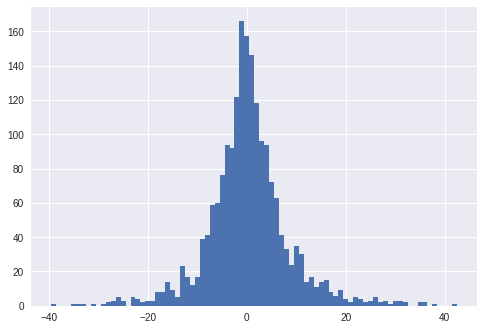

In [0]:
import matplotlib.pyplot as plt
plt.hist(err, bins=np.arange(min(err), max(err) + 1, 1))
plt.show()

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 47, 637, 4)        36        
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 637, 4)        16        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 634, 8)        264       
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 634, 8)        32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 317, 8)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 317, 8)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 314, 16)       1040      
__________

In [0]:
from keras.models import Model
from keras.layers import RepeatVector, Input, Reshape
from keras.applications import inception_v3

inputs = Input(shape=(48, 640, 1))
reshaped1 = Reshape(target_shape=((48 * 640 * 1,)))(inputs)
repeated = RepeatVector(n=3)(reshaped1)
reshaped2 = Reshape(target_shape=(48, 640, 3))(repeated)
input_model = Model(inputs=inputs, outputs=reshaped2)

base_model = inception_v3.InceptionV3(input_tensor=input_model.output, weights='imagenet', include_top=False)

combined_model = Model(inputs=input_model.input, outputs=base_model.output)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


ValueError: ignored